In [ ]:
import sys, os
repo_root = os.path.abspath(os.path.join(".."))

if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

print("PYTHONPATH set to:", repo_root)

sys.path.append('../')
sys.path.append('../cmouse/')
sys.path.append('../mouse_cnn/')
from anatomy import *
from architecture import *
%matplotlib inline

from config import *
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

import random
import seaborn as sns

import json

PYTHONPATH set to: c:\Users\canda\Documents\mousenet\Mouse_CNN\mousenet


In [2]:
def analyze_embeddings(z_w, z_v, temperature):
    # Normalize
    z_w = F.normalize(z_w, dim=1)
    z_v = F.normalize(z_v, dim=1)

    # ---- Metric 1: Recall@1 and Recall@5 ----
    sim_matrix = torch.matmul(z_w, z_v.T)
    top1 = sim_matrix.topk(1, dim=1).indices
    top5 = sim_matrix.topk(5, dim=1).indices
    top10 = sim_matrix.topk(10, dim=1).indices
    targets = torch.arange(z_w.shape[0])

    recall1 = (top1.squeeze() == targets).float().mean().item()
    recall5 = (top5 == targets.unsqueeze(1)).any(dim=1).float().mean().item()
    recall10 = (top10 == targets.unsqueeze(1)).any(dim=1).float().mean().item()
    print(f"[Temp={temperature:.2f}] Recall@1: {recall1:.3f}, Recall@5: {recall5:.3f}, Recall@10: {recall10:.3f}")

    # ---- Metric 2: Mean matched and mismatched distances ----
    matched_sims = (z_w * z_v).sum(dim=1).cpu().numpy()

    # Mismatched similarities (random pairing)
    num_samples = z_w.shape[0]
    mismatched_sims = [
        (z_w[i] * z_v[random.choice([j for j in range(num_samples) if j != i])]).sum().item()
        for i in range(num_samples)
    ]

    # Mean similarities
    mean_matched = sum(matched_sims) / len(matched_sims)
    mean_mismatched = sum(mismatched_sims) / len(mismatched_sims)

    print(f"Mean matched cosine sim: {mean_matched:.3f}")
    print(f"Mean mismatched cosine sim: {mean_mismatched:.3f}")

    # ---- Metric 3: Cosine similarity histograms ----
    matched_sims = (z_w * z_v).sum(dim=1).cpu().numpy()

    num_samples = len(z_w)
    mismatched_sims = [
        (z_w[i] * z_v[random.randint(0, num_samples - 1)]).sum().item()
        for i in range(num_samples)
    ]

    plt.figure()
    plt.hist(matched_sims, bins=30, alpha=0.6, label='Matched', color='blue')
    plt.hist(mismatched_sims, bins=30, alpha=0.6, label='Mismatched', color='red')
    plt.legend()
    plt.xlabel("Cosine Similarity")
    plt.title(f"Matched vs Mismatched Cosine Similarities (Temp={temperature:.2f})")
    plt.show()

    # ---- Metric 4: Similarity Matrix Heatmap ----
    sim_matrix_np = sim_matrix.cpu().numpy()
    plt.figure(figsize=(8, 6))
    sns.heatmap(sim_matrix_np, cmap="viridis")
    plt.title(f"Similarity Matrix (Whisker ↔ Vision) [Temp={temperature:.2f}]")
    plt.xlabel("Vision Embeddings")
    plt.ylabel("Whisker Embeddings")
    plt.show()



C:\Users\canda\AppData\Local\Temp\ipykernel_20440\1618272269.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(path)


[Temp=0.12] Recall@1: 0.147, Recall@5: 0.388, Recall@10: 0.531
Mean matched cosine sim: 0.726
Mean mismatched cosine sim: -0.011


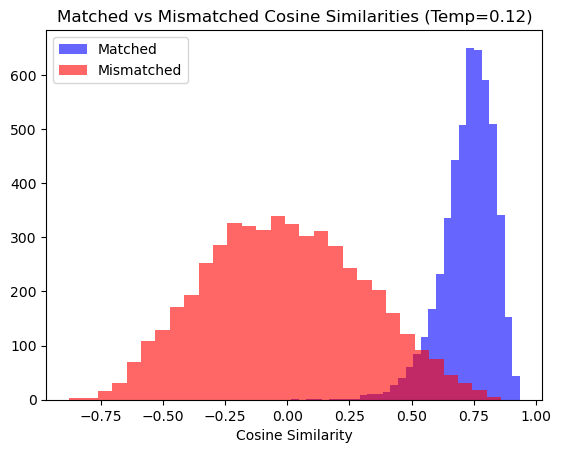

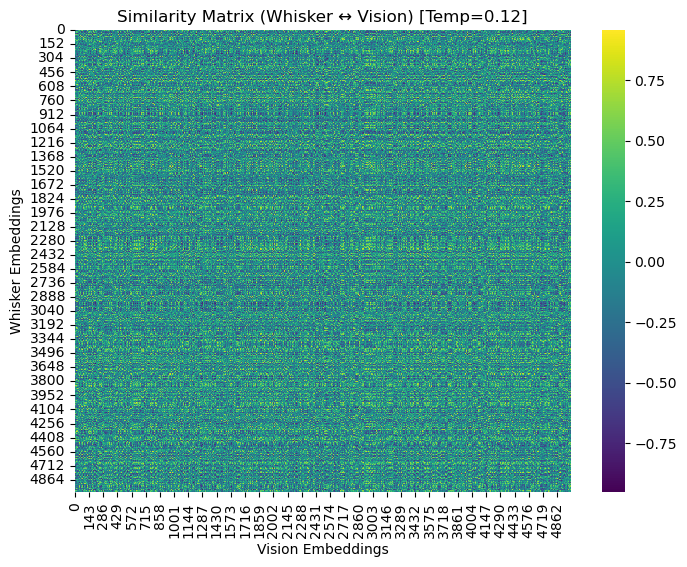

In [3]:
path = f"embeddings/embeddings_learnable_temp.pt"
state = torch.load(path)
analyze_embeddings(state['z_w'], state['z_v'], state['temperature'])

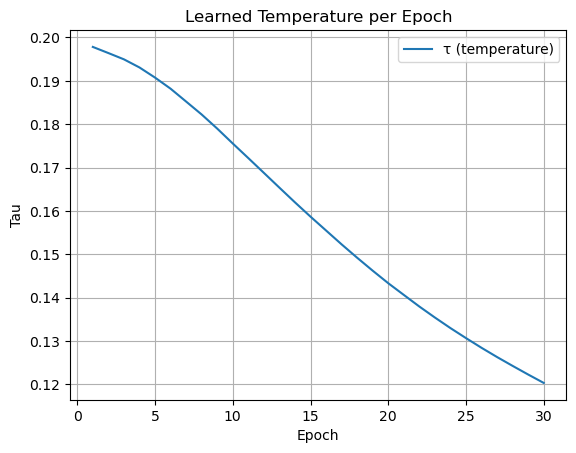

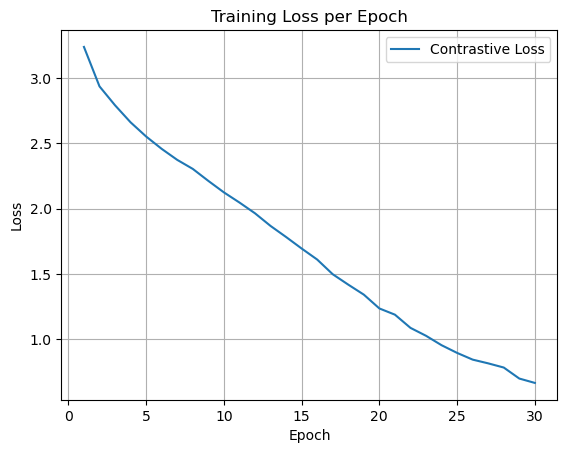

In [4]:
with open("logs/tau_tracking.json") as f:
    logs = json.load(f)

epochs = range(1, len(logs["tau"]) + 1)

plt.figure()
plt.plot(epochs, logs["tau"], label="τ (temperature)")
plt.xlabel("Epoch")
plt.ylabel("Tau")
plt.title("Learned Temperature per Epoch")
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, logs["loss"], label="Contrastive Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.grid()
plt.legend()
plt.show()

#### old code - training with fixed values of temperature

[Temp=0.01] Recall@1: 0.008, Recall@5: 0.034, Recall@10: 0.063
Mean matched cosine sim: 0.424
Mean mismatched cosine sim: 0.404


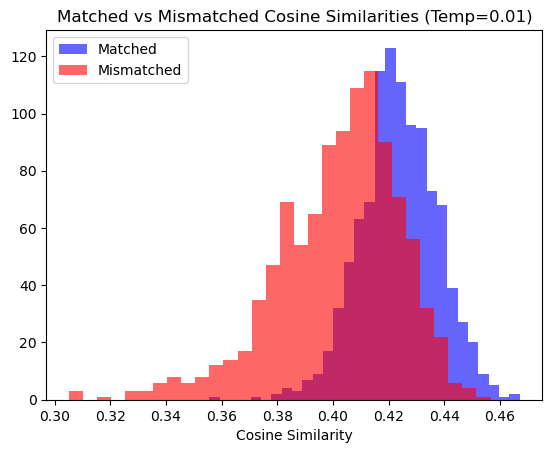

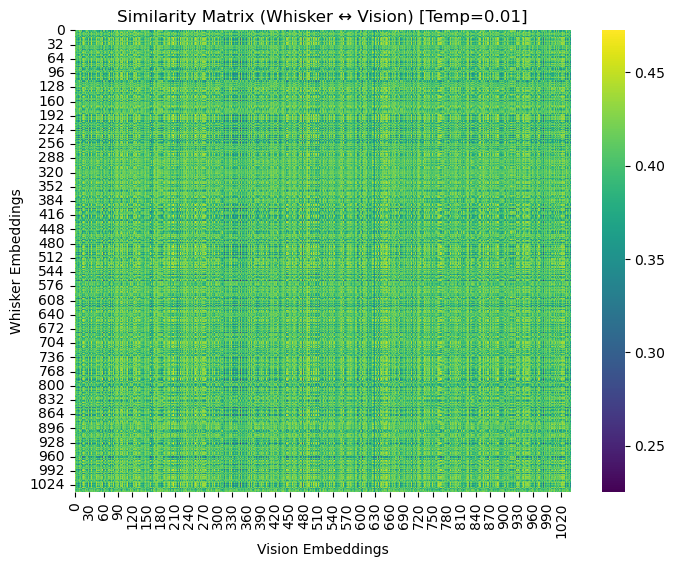

[Temp=0.07] Recall@1: 0.030, Recall@5: 0.128, Recall@10: 0.218
Mean matched cosine sim: 0.816
Mean mismatched cosine sim: 0.313


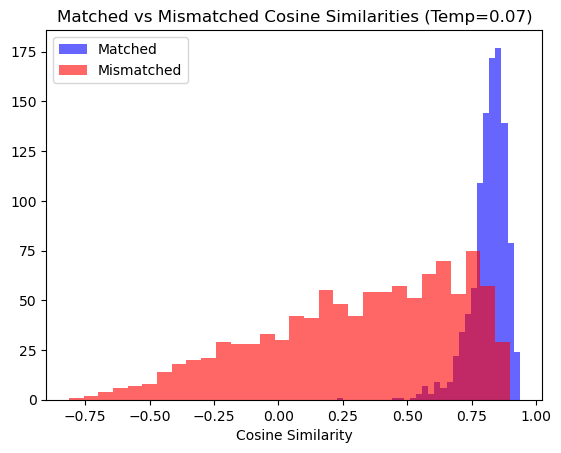

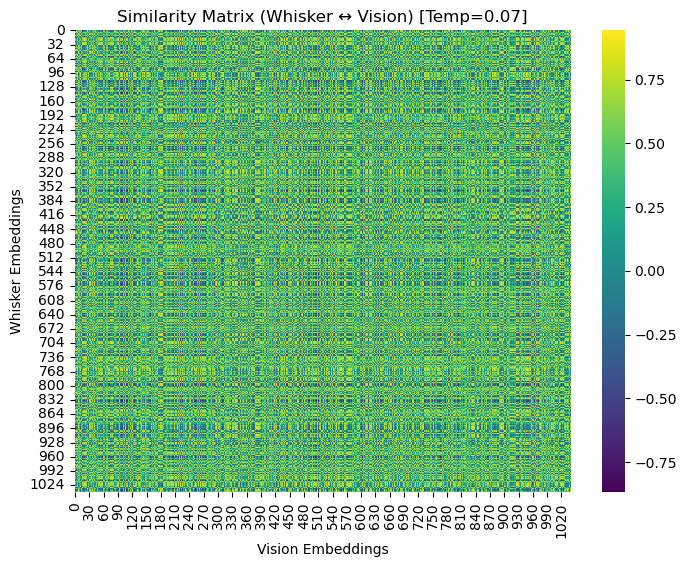

[Temp=0.10] Recall@1: 0.062, Recall@5: 0.208, Recall@10: 0.328
Mean matched cosine sim: 0.839
Mean mismatched cosine sim: 0.130


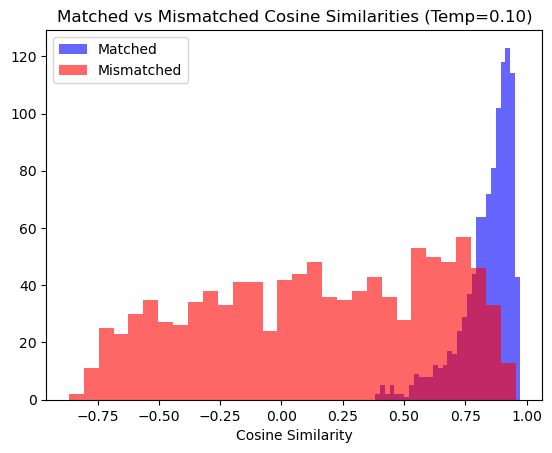

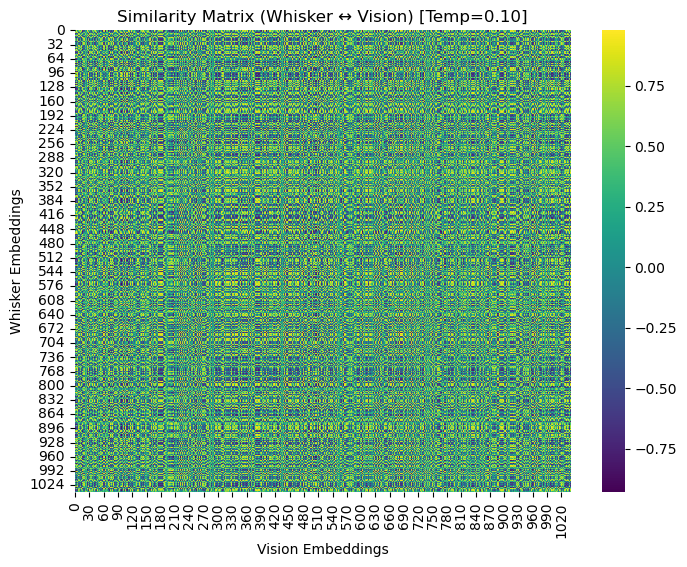

[Temp=0.15] Recall@1: 0.068, Recall@5: 0.247, Recall@10: 0.381
Mean matched cosine sim: 0.820
Mean mismatched cosine sim: -0.009


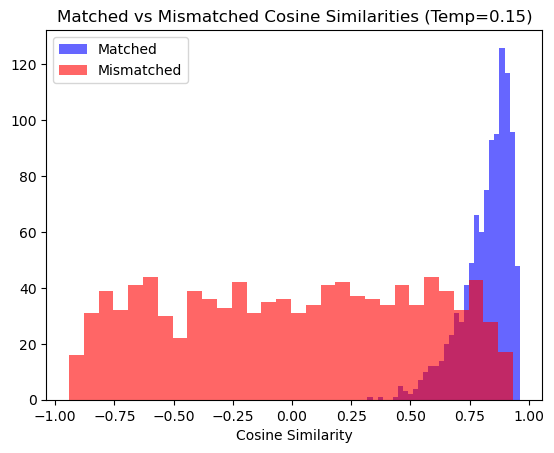

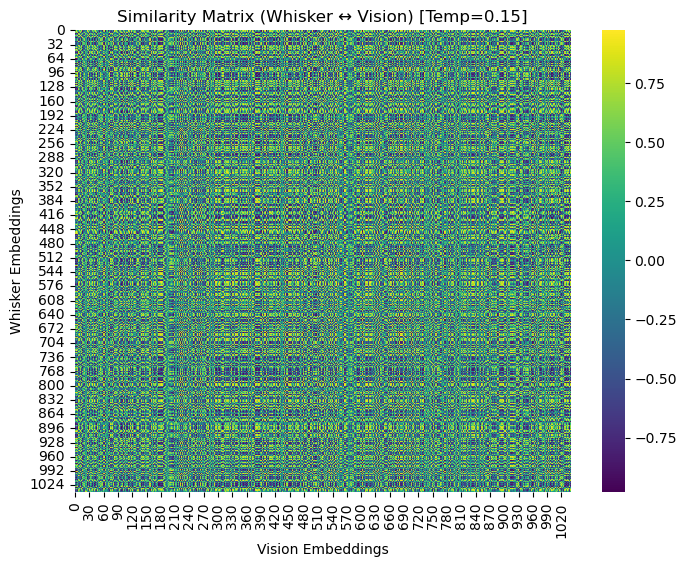

[Temp=0.20] Recall@1: 0.123, Recall@5: 0.364, Recall@10: 0.541
Mean matched cosine sim: 0.864
Mean mismatched cosine sim: 0.007


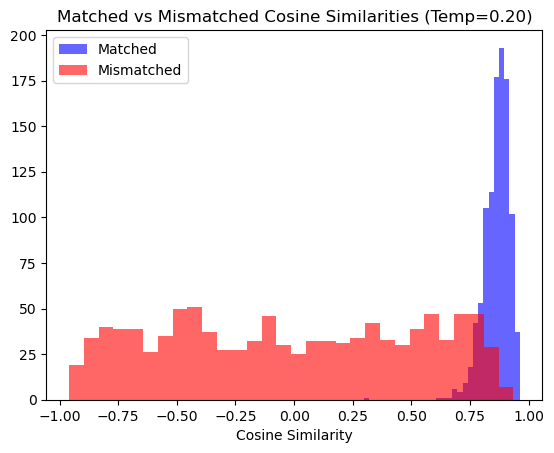

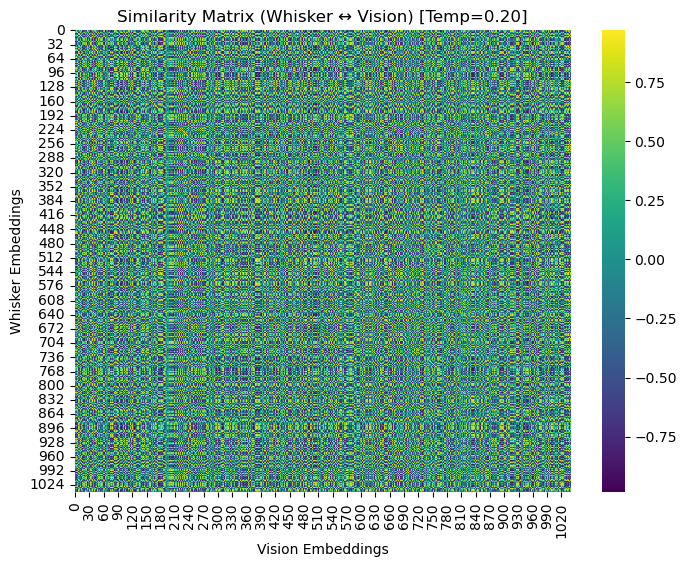

In [6]:
temperatures = [0.01, 0.07, 0.1, 0.15, 0.2]

for temp in temperatures:
    path = f"embeddings/embeddings_temp_{temp:.2f}.pt"
    try:
        state = torch.load(path)
        analyze_embeddings(state['z_w'], state['z_v'], temp)
    except FileNotFoundError:
        print(f"❌ Skipping temp={temp:.2f}: File not found")
